# Neural Network for Lidar Odometry

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
# file = "data/train_10k.npy" #has noise in readings
# file = "data/train_100k.npy" #no noise
# file = "data/train_straight_1k.npy" #no noise, no lateral movement relative to initial heading
file = "data/train_dxdy_300k.npy" #no noise, displacement in x and y relative to starting orientation

dataset = np.load(file)

In [3]:
#combine 100k and 200k datasets
# ds2 = np.load("data/train_dxdy_100k.npy")
# dataset = np.append(dataset, ds2, axis =0)
# np.save("data/train_dxdy_300k.npy", dataset)

In [4]:
dataset[0,100:]
np.shape(dataset)

(300000, 103)

In [45]:
dataset[100,:]

array([ 1.25000000e+02,  1.25000000e+02,  1.34000000e+02,  1.43000000e+02,
        1.55000000e+02,  1.68000000e+02,  1.84000000e+02,  2.03000000e+02,
        2.26000000e+02,  2.54000000e+02,  2.53000000e+02,  2.52000000e+02,
        2.52000000e+02,  2.51000000e+02,  2.51000000e+02,  2.51000000e+02,
        2.51000000e+02,  2.51000000e+02,  2.51000000e+02,  2.51000000e+02,
        2.51000000e+02,  2.52000000e+02,  2.52000000e+02,  2.53000000e+02,
        2.54000000e+02,  2.55000000e+02,  2.56000000e+02,  2.57000000e+02,
        2.58000000e+02,  2.42000000e+02,  2.25000000e+02,  2.10000000e+02,
        1.97000000e+02,  1.85000000e+02,  1.75000000e+02,  1.69000000e+02,
        1.71000000e+02,  1.72000000e+02,  1.74000000e+02,  1.76000000e+02,
        2.84000000e+02,  2.88000000e+02,  2.91000000e+02,  2.95000000e+02,
        2.99000000e+02,  3.03000000e+02,  3.08000000e+02,  3.12000000e+02,
        3.17000000e+02,  3.23000000e+02,  1.68000000e+02,  1.68000000e+02,
        1.83000000e+02,  

In [5]:
from network import Net1, Net2

np.random.seed(1337)

#convert data from numpy to tensors
# x_train = tf.convert_to_tensor(dataset[:,:100])

#alternate dataset where we are just looking at the changes in measurement from the first sample to the 2nd
x_temp = tf.convert_to_tensor(dataset[:,:100])
x_train = np.zeros([np.shape(dataset)[0], 50])
x_train[:,:50] = x_temp[:,:50] - x_temp[:,50:100]

print(np.shape(x_train))

y_train = tf.convert_to_tensor(dataset[:,100:])

(300000, 50)


In [19]:
model = Net1() # 50 input data (looking at differences in measurememnt between each point) 
# model = Net2() # 100 input network (looking at full data)

runLen = 100    
BS = 32 #128 #256 #works well

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6

#     part1 = runLen//3
#     part2 = 2*runLen//3

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr

#TODO: figure out how to implement sample weight
# L = tf.keras.losses.MeanAbsoluteError()
# sample_weight = [0.3,0.3,0.4]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
#     loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
#     loss = tf.keras.losses.MeanAbsolutePercentageError(),
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=BS, epochs=runLen, verbose=1, 
                  validation_split=0.05, callbacks = [callback], shuffle=True)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 50, 1)             4         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 128)           768       
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 128)           512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 128)           49280     
_________________________________________________________________
flatten_2 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

8907/8907 [==============================] - 29s 3ms/step - loss: 1.3285 - val_loss: 1.4042
Epoch 61/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3322 - val_loss: 1.9675
Epoch 62/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3270 - val_loss: 1.5644
Epoch 63/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3211 - val_loss: 1.3268
Epoch 64/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3231 - val_loss: 1.4763
Epoch 65/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3187 - val_loss: 1.4575
Epoch 66/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.3227 - val_loss: 1.3002
Epoch 67/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.2787 - val_loss: 1.2702
Epoch 68/100
8907/8907 [==============================] - 29s 3ms/step - loss: 1.2720 - val_loss: 1.3438
Epoch 69/100
8907/8907 [==============================] - 29s 3ms/st

Text(0, 0.5, 'loss')

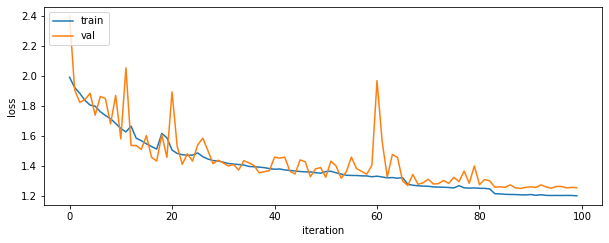

In [32]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [87]:
r = int(np.random.rand()*100)
print(y_train[r])
# out = model.predict(x_train)
print(out[r])

tf.Tensor([ 6.35746061  2.87179544 -0.06358878], shape=(3,), dtype=float64)
[ 5.540073    2.485626   -0.03683225]


In [80]:
test_file = "data/test_dxdy.npy"
test_dataset = np.load(test_file)
rand = int(np.shape(test_dataset)[0]*np.random.rand())

#test for standard case
# x_test = test_dataset[:,:100]
# x_test = tf.convert_to_tensor(x_test)

#test when looking at displacement between two measurements
x_temp2 = tf.convert_to_tensor(test_dataset[:,:100])
x_test = np.zeros([np.shape(test_dataset)[0], 50])
x_test[:,:50] = x_temp2[:,:50] - x_temp2[:,50:100]

y_test = test_dataset[:,100:]
y_test = tf.convert_to_tensor(y_test)
# print(y_test[rand])
print(y_train[rand])

# guess = model.predict(x_test)
guess = model.predict(x_train)
print(guess[rand])

tf.Tensor([-0.55375167 -2.85650712  0.07779664], shape=(3,), dtype=float64)
[ 0.74294055 -2.167066    0.04748894]


In [ ]:
# model.save("dead_reckoning_1pt22_mse.kmod") #got this with 50 input model

Results:

Best MSE with 100k dataset: 1.36

Best MSE with 300k dataset: 1.22

# Normal Distribution Transform (NDT)

Step 2: generate a normal distribution for each subset of points

In [50]:
from NDT import fit_gaussian

numpts = 10
points = np.random.randn(numpts, 2)

#adds order to points
# points[:,0] += np.linspace(1,10,numpts)
# points[:,1] += np.linspace(0,2,numpts)
 
mu, sigma = fit_gaussian(points)
print("mu = ", mu)
print("sigma = ", sigma)

eig = np.linalg.eig(sigma)
eigenval = eig[0]
eigenvec = eig[1]

print("eigenval = ", eigenval)
print("eigenvec = ", eigenvec)


mu =  [0.18090625 0.16389922]
sigma =  [[1.11806662 0.25747504]
 [0.25747504 0.52449994]]
eigenval =  [1.21418753 0.42837903]
eigenvec =  [[ 0.93684522 -0.34974424]
 [ 0.34974424  0.93684522]]


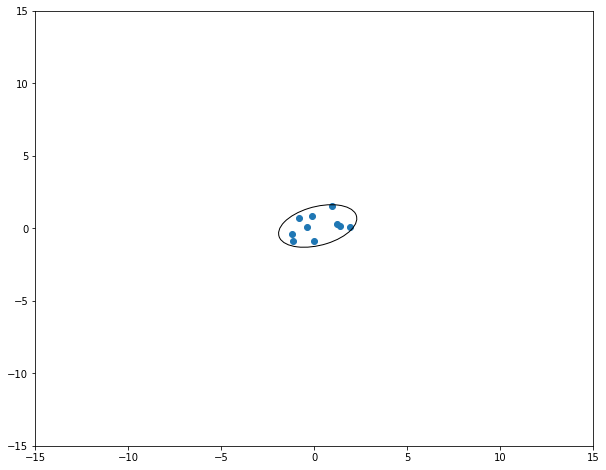

In [51]:
#draw ellipse around 1std to prove fit_guassian works
from matplotlib.patches import Ellipse

nstd = 2

fig2 = plt.figure(1)
ax2 = fig2.add_subplot()

patches = []

ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.scatter(points[:,0], points[:,1])

rot = -np.rad2deg(np.arcsin(eigenvec[0,1]/eigenvec[0,0]))
width = 2*nstd*np.sqrt(eigenval[0])
height = 2*nstd*np.sqrt(eigenval[1])

ell = Ellipse((mu[0],mu[1]),width, height, angle = rot, fill = False)
ax2.add_patch(ell)


Step 1: Subdivide scan into grid cells:

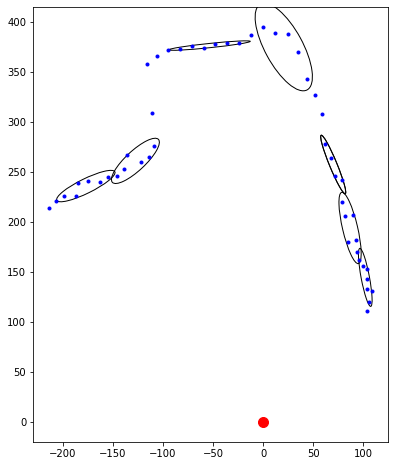

In [251]:
from NDT import draw_scan, subdivide_scan

fig3 = plt.figure(1)
ax3 = fig3.add_subplot()
ax3.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway

# dat = dataset[:,:50] #regular data
dat = np.load("data/noisy_dxdy_100.npy")  #noisy data
dat = dat[:,:50]

#get point positions and draw lidar scan
pp = draw_scan(dat[rand2],fig3,ax3) 

f = 6 #overall region of scan is broken down into a 5x5 scan
subdivide_scan(pp,fig3,ax3, fidelity = f)

[-123.46778428  200.955184  ]
[-87.27399906 192.78488611]
[-61.91633162 201.83626343]
[ 48.77371485 142.85206845]
[ 82.00594272 116.84972365]


In [135]:
temp = pp[pp[:,0] < 0]
temp = temp[temp[:,1] > 250]
temp

array([[-77.87713718, 348.40228401],
       [-65.58346011, 343.80053776],
       [-53.81345597, 339.76478916],
       [-42.36263294, 335.33476904],
       [-31.24396002, 330.52657225],
       [-20.53249989, 326.3547402 ],
       [-10.11426442, 321.84111244]])